# PlantCV
[PlantCV](https://plantcv.danforthcenter.org/) is an open-source image analysis software package targeted for plant phenotyping. PlantCV is modular and modules are used to build image analysis workflows. Jupyter notebooks like this document are a great way to build and visualize PlantCV workflows. This notebook is a starter notebook that only has the essential code to get started but is meant to be filled out during a class/workshop.

## Import packages
The first block of code starts with an IPython "magic" command that configures matplotlib display behavior. We use two matplotlib modes: `inline` simply displays an image/plot; `notebook` displays an interactive panel.

Next we import any packages we need, including PlantCV.

In [1]:
%matplotlib inline
import cv2
import numpy as np
from plantcv import plantcv as pcv
import skimage
import matplotlib.pyplot as plt

## Boilerplate code
The following few cells setup some minimal code we need to make a functioning PlantCV environment and print some informational content.

1. Print the version of PlantCV.
2. Setup a placeholder input handler that will be replaced later with command-line input handling.
3. Read the input options.
4. Set the PlantCV "debug" mode, we want "plot" mode for notebooks.

In [4]:
# Print the PlantCV version
pcv.__version__

'3.9.0+31.ge628b2e'

In [5]:
# Handle input variables
# This code was provided to make it easier to convert the notebook to a script
class options():
    def __init__(self):
        self.debug = "plot"
        self.result = "CoVar_0307.txt"
        self.outdir = "./output_images"
        self.writeimg = False
        self.image = "./silphium_integrifolium/CoVar_0307.tif"

In [6]:
# Create input arguments object
args = options()

In [7]:
# Set debug mode
pcv.params.debug = args.debug
pcv.params.line_thickness = 30
pcv.params.dpi = 200

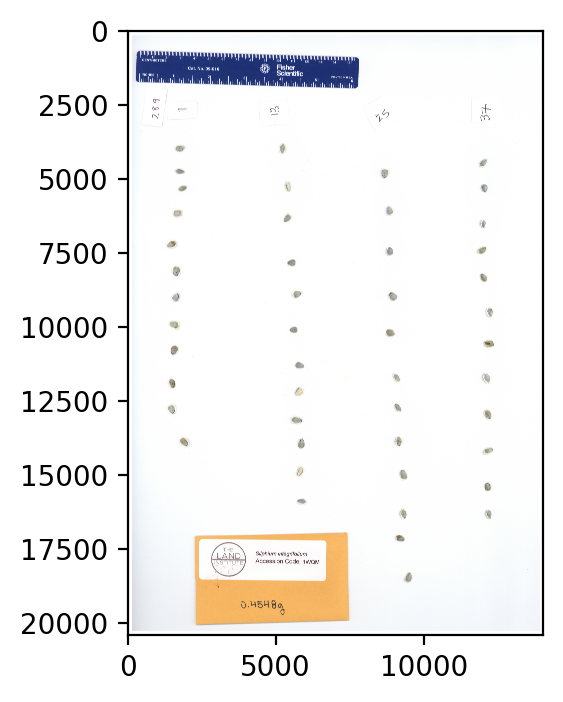

In [8]:
# Open image
img, imgpath, imgname = pcv.readimage(filename=args.image)

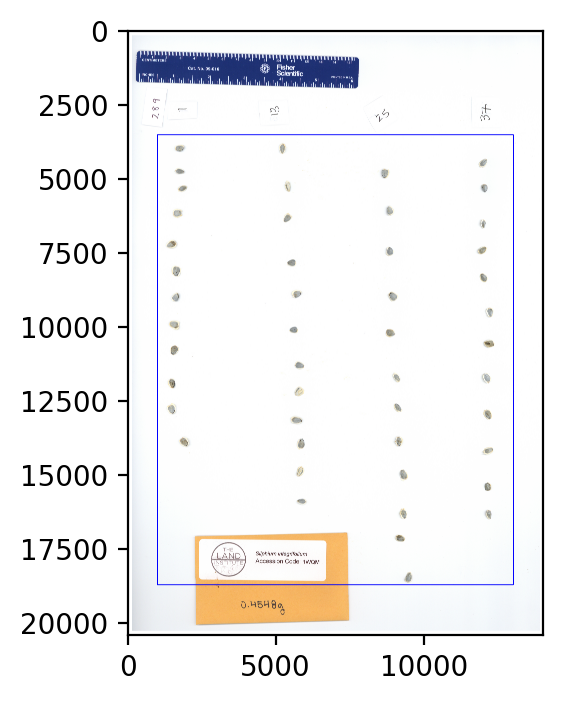

In [9]:
# Create a region of interest that encloses all the seed
roi, roi_str = pcv.roi.rectangle(img=img, x=1000, y=3500, h=15200, w=12000)

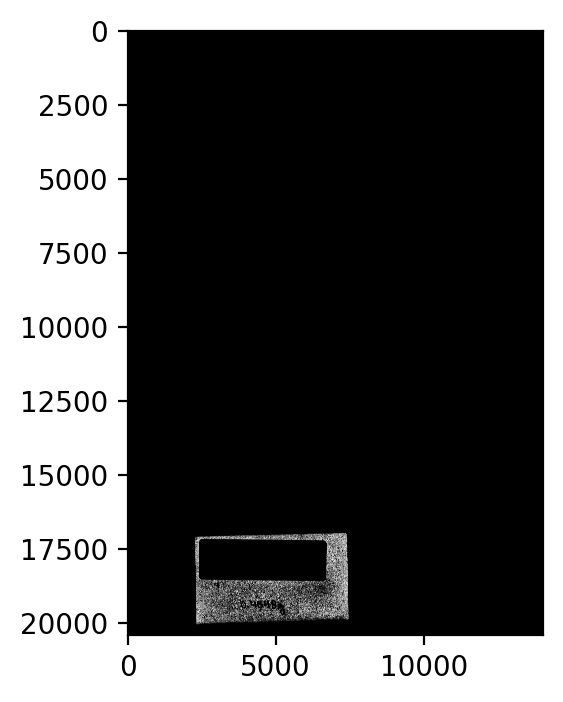

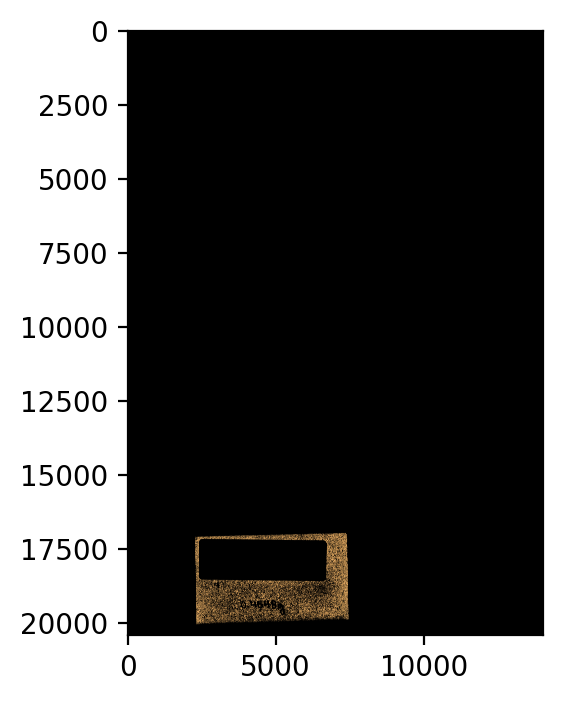

In [10]:
# Sometimes the seed packet is within the region of interest
# Use an RGB threshold to find the seed packet
packet_mask, packet_img = pcv.threshold.custom_range(img=img, lower_thresh=[244, 178, 100], upper_thresh=[255, 190, 120], channel="rgb")

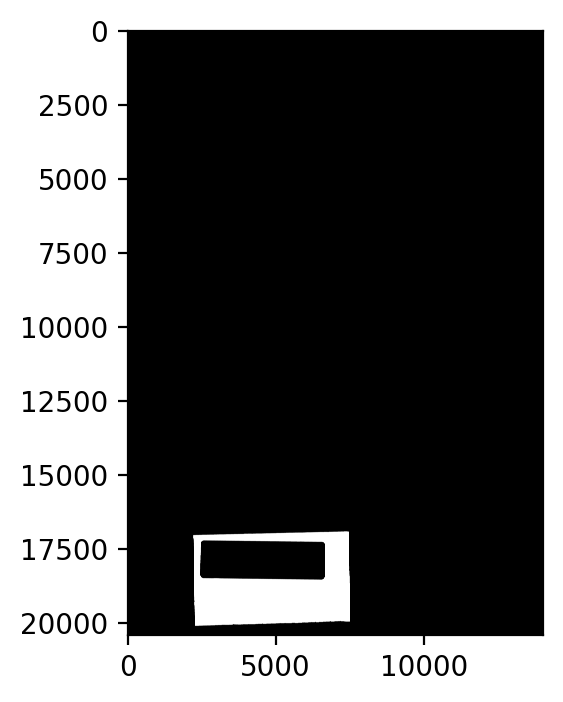

In [11]:
# Dilate the edges of the seed packet to include the edges
packet_dil = pcv.dilate(gray_img=packet_mask, ksize=9, i=13)

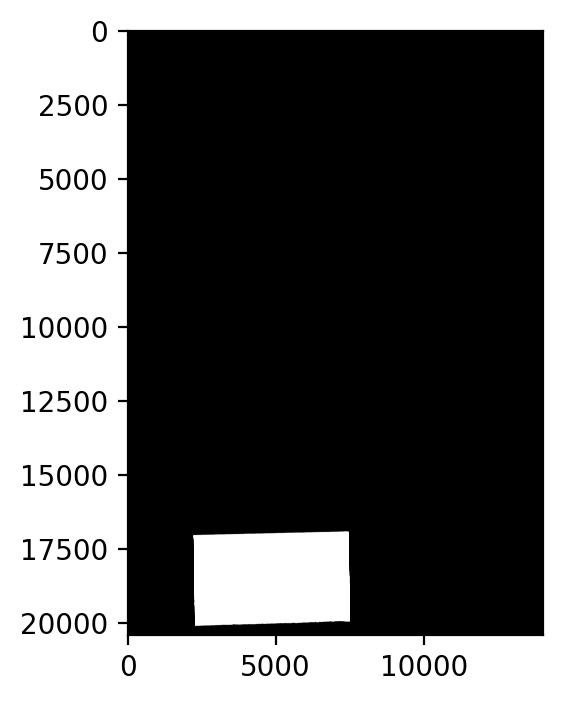

In [12]:
# Fill in missing pixels within the seed packet binary mask
packet_cleaned = pcv.fill_holes(bin_img=packet_dil)

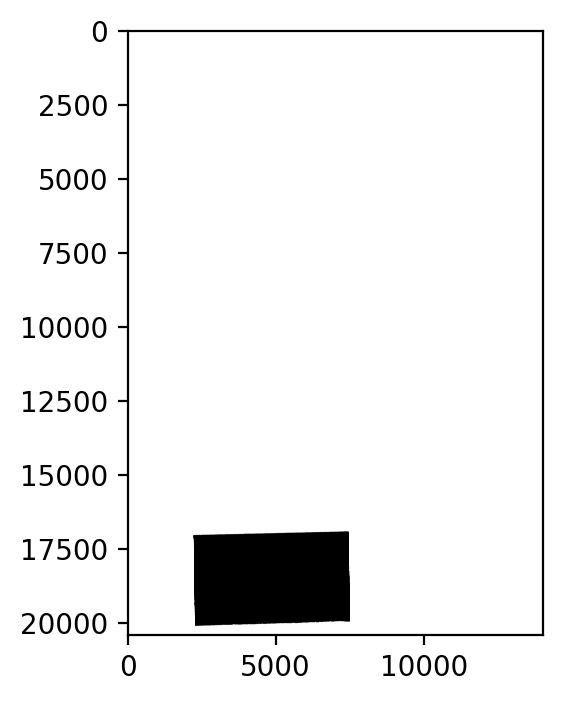

In [13]:
# Invert the packet mask
img_mask = pcv.invert(gray_img=packet_cleaned)

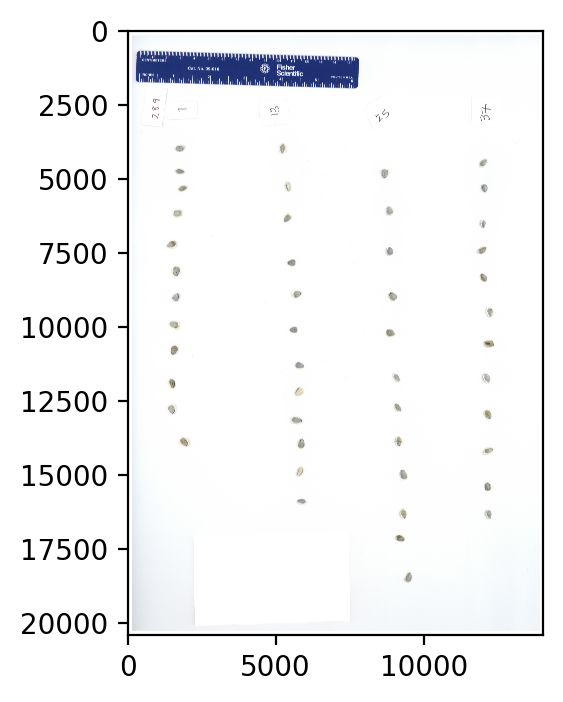

In [14]:
# Apply the inverted packet mask to the original image to remove the seed packet
img_no_packet = pcv.apply_mask(img=img, mask=img_mask, mask_color="white")

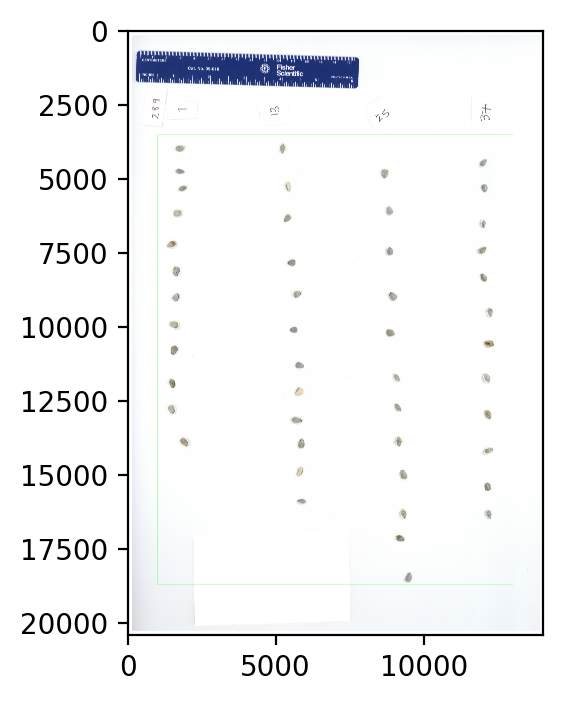

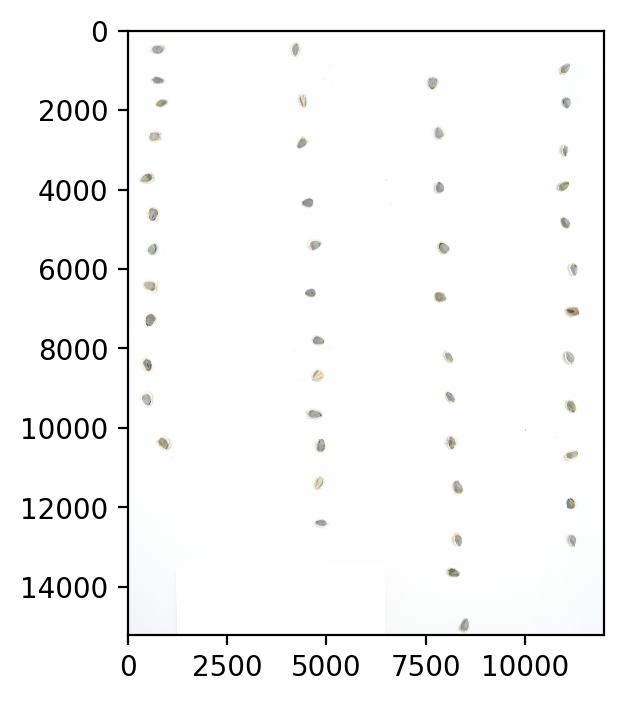

In [15]:
# Crop the image to the ROI
cropped_img = pcv.auto_crop(img=img_no_packet, obj=roi[0])

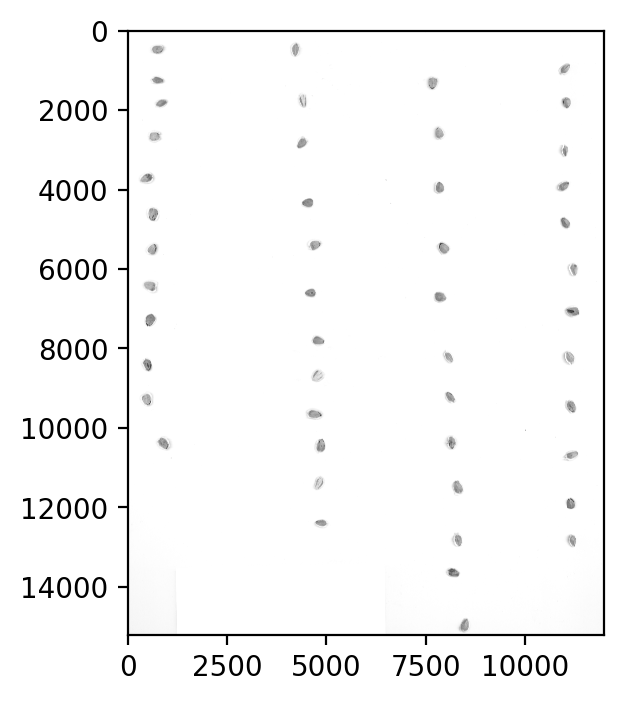

In [16]:
# Convert RGB image to grayscale using LAB "L" channel
gray_img = pcv.rgb2gray_lab(rgb_img=cropped_img, channel="l")

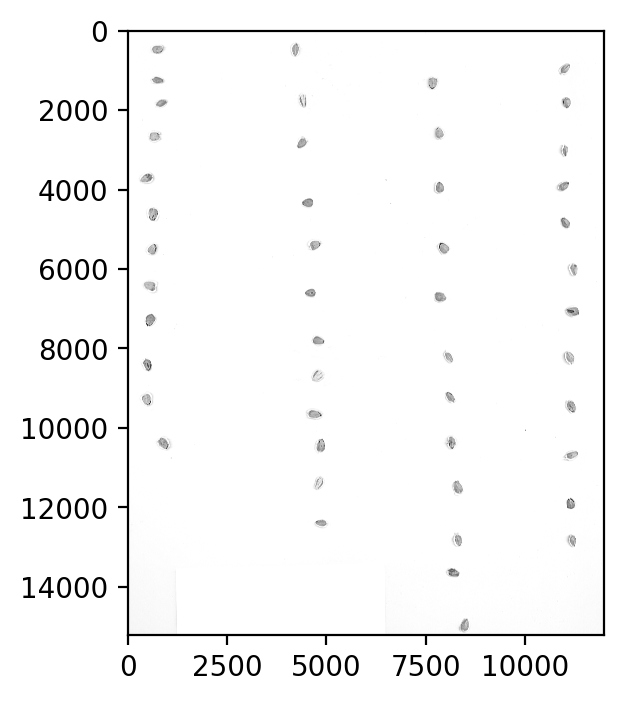

In [17]:
# Sharpen the image using the unsharp mask technique
unsharp = skimage.filters.unsharp_mask(gray_img, radius=20, amount=1)
rescaled_unsharp = pcv.transform.rescale(unsharp)

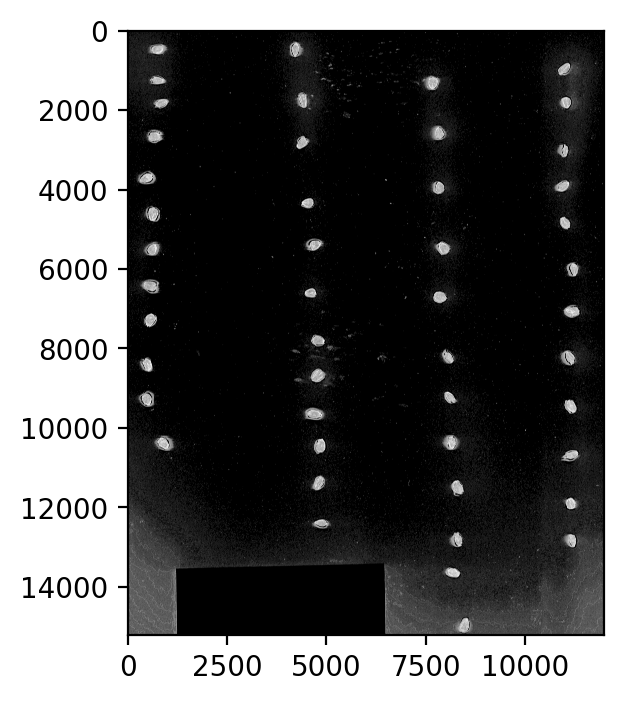

In [18]:
# Enhance seed regions using an entropy filter
entropy = skimage.filters.rank.entropy(rescaled_unsharp, skimage.morphology.disk(10))
# Rescale the entropy image to unsigned 8-bit data type
scaled_entropy = pcv.transform.rescale(entropy)

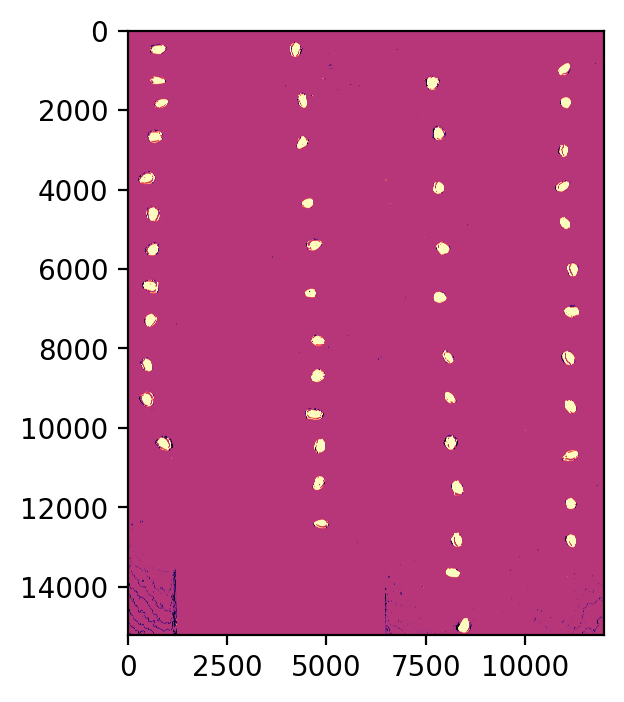

In [26]:
from skimage.segmentation import random_walker
from skimage.exposure import rescale_intensity
import skimage
data = rescale_intensity(scaled_entropy.astype(np.float), in_range=(0, 255), out_range=(-1, 1))
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.1] = 1
markers[data > 0.1] = 2
pcv.plot_image(markers, cmap="magma")

In [ ]:
labels = random_walker(data, markers, beta=10, mode="cg_mg")

In [2]:
pcv.plot_image(labels)

NameError: name 'pcv' is not defined

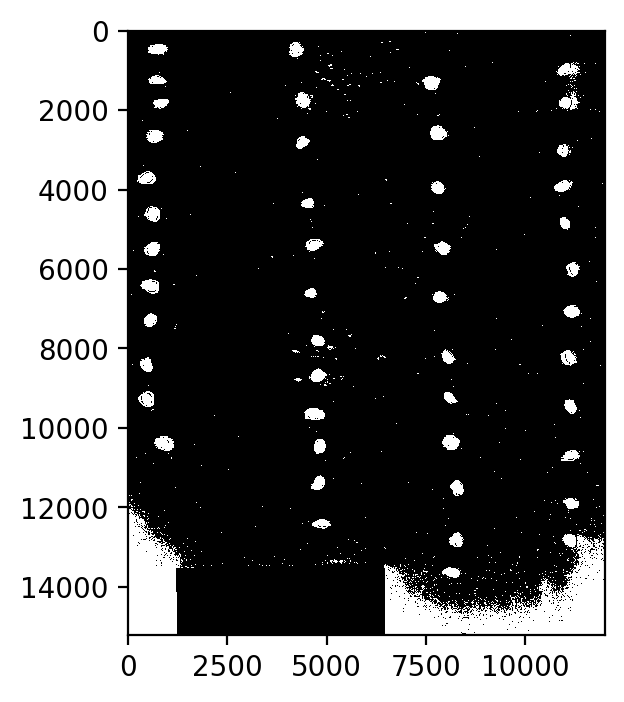

In [31]:
# Use the Otsu autothreshold method to segment seeds from background
bin_img = pcv.threshold.otsu(gray_img=scaled_entropy, max_value=255, object_type="light")

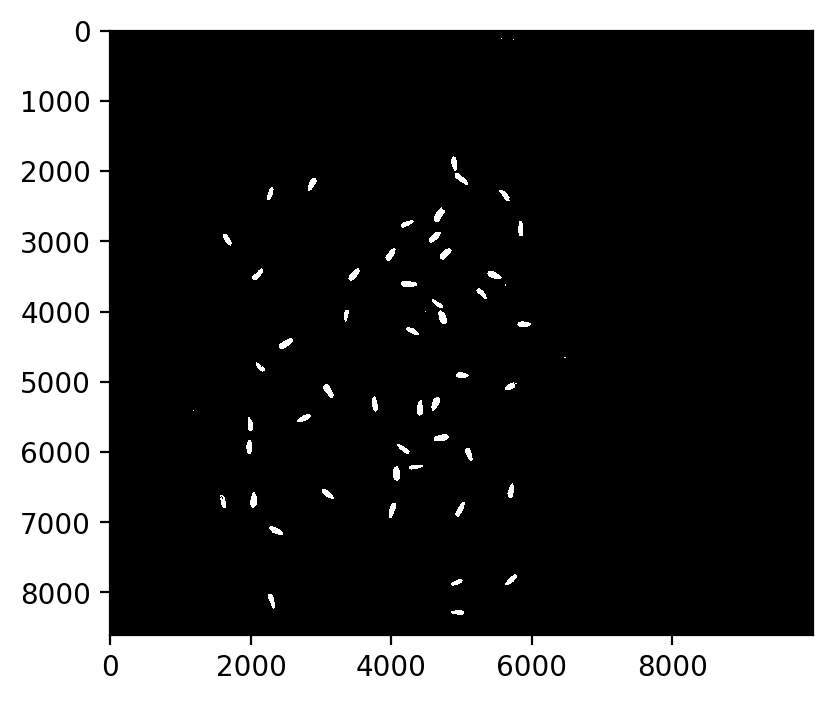

In [157]:
# Fill in holes in seeds
clean_mask = pcv.fill_holes(bin_img)

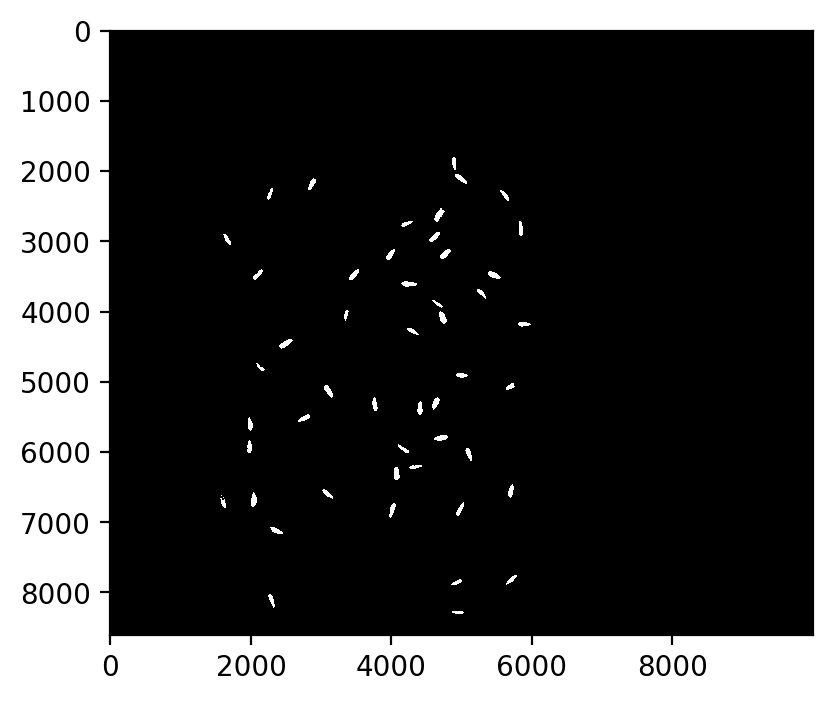

In [158]:
# There is a shadow around the seeds, use erosion to remove it
er = pcv.erode(gray_img=clean_mask, ksize=7, i=2)

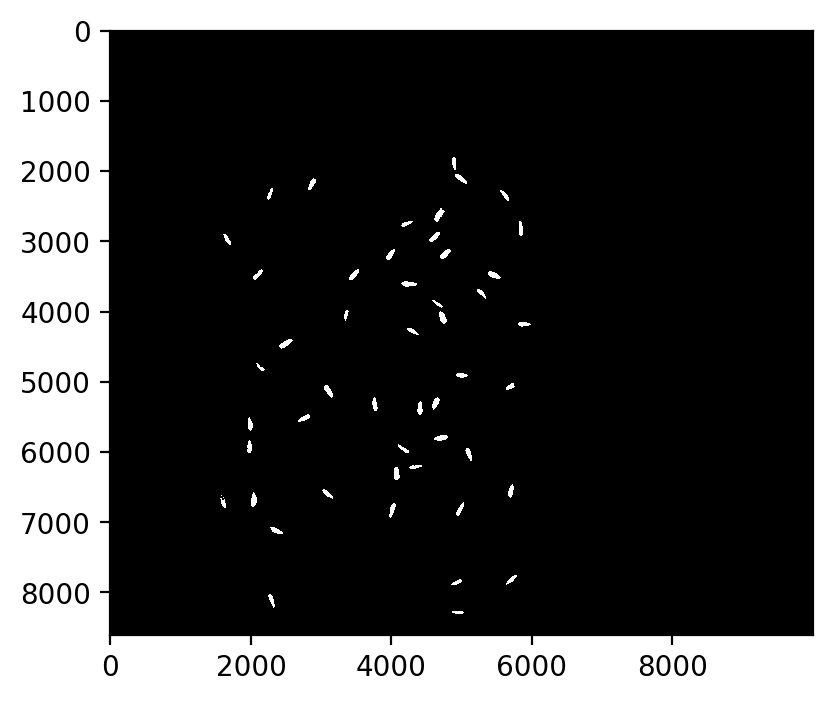

In [159]:
# Remove small, non-seed background objects
cleaned = pcv.fill(bin_img=er, size=1000)

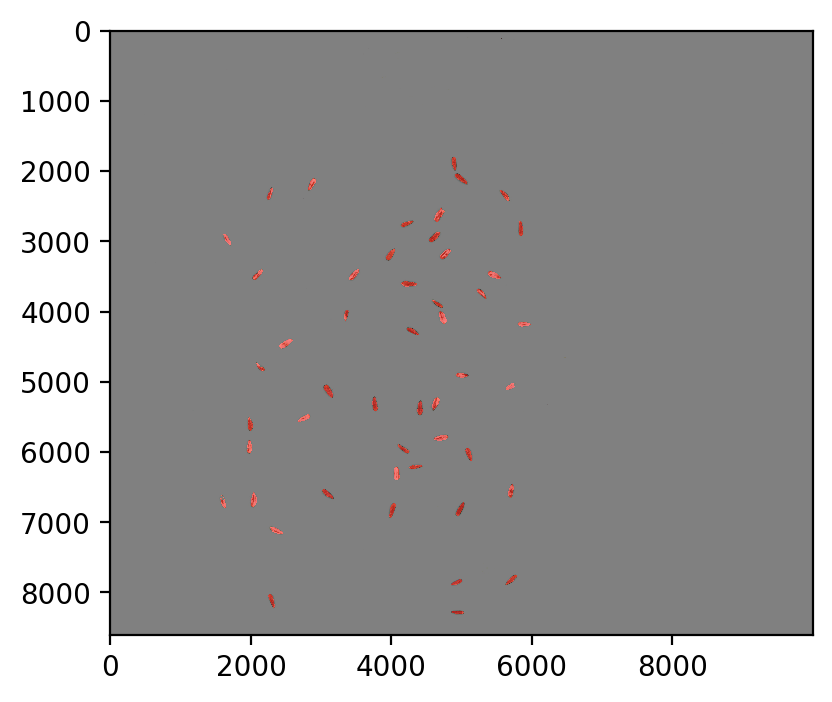

In [160]:
# Visualize the mask overlaid on the original image
output = np.copy(cropped_img)
overlay = cv2.addWeighted(cv2.merge([np.zeros(np.shape(cleaned), dtype=np.uint8), np.zeros(np.shape(cleaned), dtype=np.uint8), cleaned]), 0.5, output, 0.5, 0, output)
pcv.plot_image(overlay)

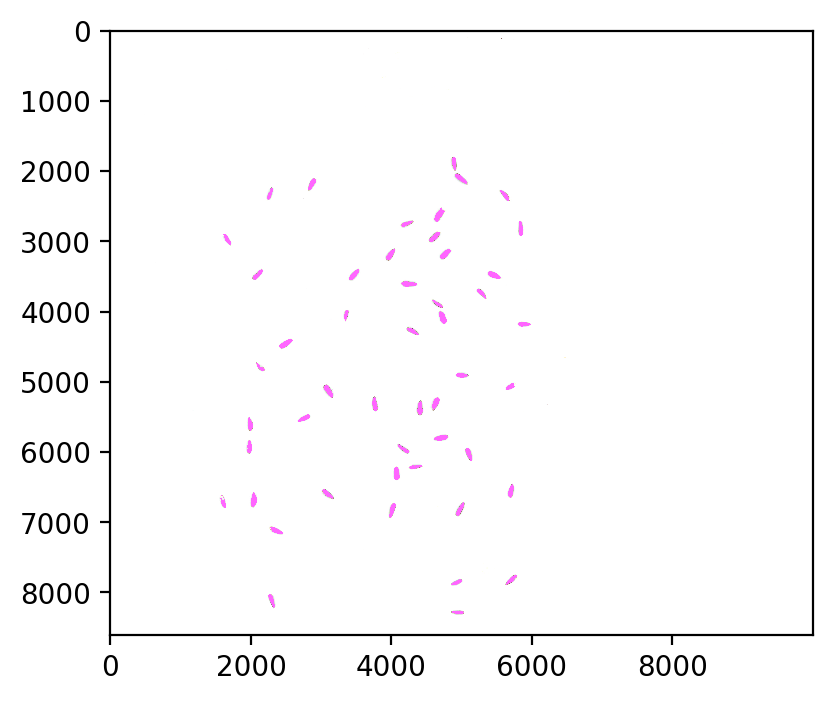

In [161]:
# Find seeds
seeds, seeds_str = pcv.find_objects(img=cropped_img, mask=cleaned)

In [ ]:
# The result file should exist if plantcv-workflow.py was run
if os.path.exists(args.result):
    # Open the result file
    results = open(args.result, "r")
    # The result file would have image metadata in it from plantcv-workflow.py, read it into memory
    metadata = results.read()
    # Close the file
    results.close()
    # Delete the file, we will create new ones
    os.remove(args.result)
else:
    # If the file did not exist (for testing), initialize metadata as an empty string
    metadata = "{}"

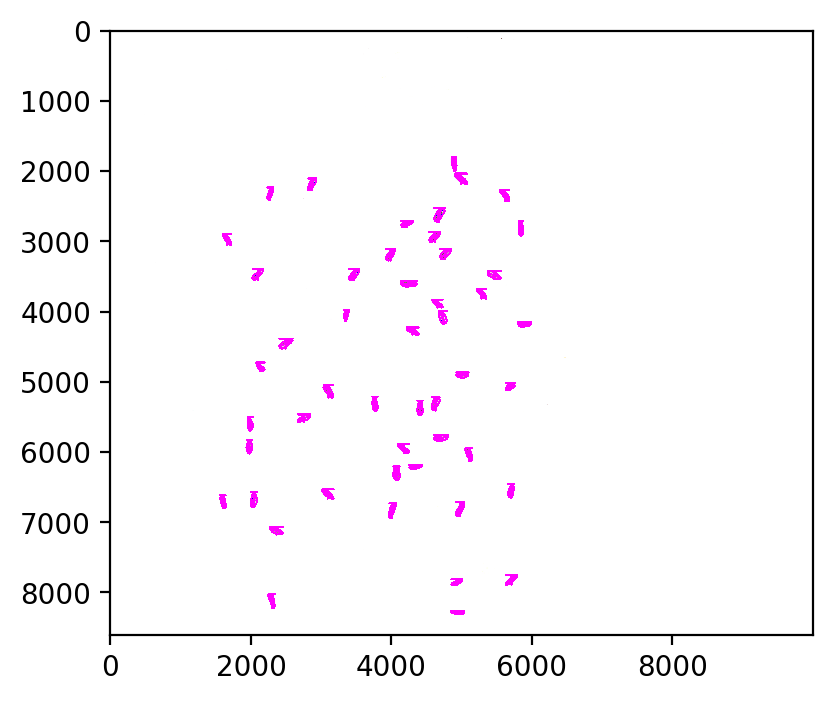

In [162]:
# Create a copy of the cropped image for visualization
seed_shape = np.copy(cropped_img)
# Loop over all the seeds
for i in range(0, len(seeds)):
    # Create a seed-specific binary mask
    seed_mask = np.zeros(np.shape(gray_img), dtype=np.uint8)
    cv2.drawContours(seed_mask, seeds, i, (255), -1, hierarchy=seeds_str)
    pcv.params.debug = None
    # Find the contour of the single seed
    seed, seed_str = pcv.find_objects(img=cropped_img, mask=seed_mask)
    sseed, smask = pcv.object_composition(img=cropped_img, contours=seed, hierarchy=seed_str)
    # Measure the shape of the individual seed
    seed_shape = pcv.analyze_object(img=seed_shape, obj=sseed, mask=smask)
    # Measure the color of the individual seed
    color_hist = pcv.analyze_color(rgb_img=cropped_img, mask=smask, hist_plot_type="hsv")
    # Add custom output
    pcv.outputs.add_observation(
            variable='seed_index',
            trait='seed index',
            method='arbitrary',
            scale='int',
            datatype=int,
            value=i,
            label='index')
    # At this point we have observations for one seed
    # We can write these out to a unique results file
    # Here the name of the results file will have the seed index combined with the original result filename
    filename = str(i) + "_" + args.result
    # Save the existing metadata to the new file
    with open(filename, "w") as r:
        r.write(metadata)
    pcv.print_results(filename=filename)
    # The results are saved, now clear out the observations so the next loop adds new ones for the next seed
    pcv.outputs.clear()
pcv.plot_image(seed_shape)